In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Number of GPUs available: ',torch.cuda.device_count())
device

Number of GPUs available:  0


device(type='cpu')

In [10]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_feature, out_feature, num_layers, pool = False):
        super(ConvBlock, self).__init__()
        channels = [in_feature] + [out_feature for i in range(num_layers)]
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size= 3, padding= 1, bias = True))
            layers.append(nn.BatchNorm2d(channels[i+1], affine = True, track_running_stats= True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size= 2, stride = 2, padding= 0))
            
        self.op = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.op(x)

In [11]:
class Vgg(nn.Module):
    
    def __init__(self):
        super(Vgg, self).__init__()
        self.conv_block1 = ConvBlock(3, 64, 2)
        self.conv_block2 = ConvBlock(64, 128, 2)
        self.conv_block3 = ConvBlock(128, 256, 3)
        self.conv_block4 = ConvBlock(256, 512, 3)
        self.conv_block5 = ConvBlock(512, 512, 3)
        self.fc1 = nn.Linear(in_features= 512*4*4, out_features= 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        #feed forward
        x = self.conv_block1(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /16
        x = self.conv_block2(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /8
        x = self.conv_block3(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /4
        x = self.conv_block4(x)
        #x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0) # /2
        x = self.conv_block5(x)
        #x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0)
        
        B, C, H, W = x.shape
        l = x.reshape(-1, C*H*W)
        l = self.fc1(l)
        l = F.relu(l)
        #l = F.dropout2d(l)
        l = self.fc2(l)
        l = F.relu(l)
        out = self.fc3(l)
        
        return F.softmax(out)

In [5]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [6]:
data = Data()
train, test = data.get_data()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train, batch_size= 128, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

In [8]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([128, 3, 32, 32])

In [56]:
labels

tensor([3, 1, 1, 6, 7, 1, 4, 5, 0, 0, 5, 0, 0, 9, 7, 6, 8, 7, 0, 8, 3, 7, 4, 9,
        8, 1, 5, 0, 4, 9, 2, 5, 2, 0, 9, 7, 6, 1, 9, 9, 5, 2, 0, 8, 1, 1, 9, 7,
        0, 0, 2, 3, 3, 7, 0, 1, 1, 8, 0, 2, 7, 5, 0, 5, 6, 2, 6, 2, 4, 9, 7, 5,
        2, 7, 9, 1, 4, 1, 0, 4, 9, 6, 5, 9, 4, 5, 3, 0, 9, 3, 9, 4, 9, 5, 3, 1,
        3, 5, 3, 2, 8, 1, 5, 8, 7, 1, 1, 6, 5, 9, 5, 1, 0, 6, 7, 3, 0, 8, 5, 6,
        0, 9, 5, 9, 3, 9, 3, 2])

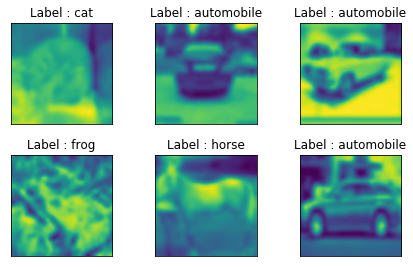

In [57]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], interpolation='bicubic')
  plt.title("Label : {}".format(train.classes[labels[i]]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
net = Vgg()
# use multiple gpus
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
    
net.to(device)

Vgg(
  (conv_block1): ConvBlock(
    (op): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (op): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (op): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [13]:
def train(train_loader, epochs, optimizer, losses):
    
    for idx, (images, labels) in enumerate(train_loader):
        net.train()
        images = images.to(device) 
        labels = labels.to(device)
        optimizer.zero_grad()
        
        output = net(images)
        
        loss = F.nll_loss(output, labels)
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item())
        
        if idx % 50 == 0:
            print('epoch {} loss {}'.format(epoch, loss.item()))

In [14]:
def test(test_loader ):
    
    test_loss = 0
    correct = 0
    net.eval()
    for idx, (images,labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        test_loss += F.nll_loss(output, labels).item()
        pred = output.data.max(dim = 1, keepdim = False)[1]  #get the labels/indices corresponding to the class
        correct += pred.eq(labels.view_as(pred)).sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
torch.cuda.empty_cache()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.5 , nesterov= True)
losses = []
epochs = 1
for epoch in range(1,epochs+1):
    train(train_loader, epoch, optimizer, losses)
    test(test_loader)

C:\Users\Tushara\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1 loss -0.10007937997579575
